## Import Libraries. Load and filter dataset.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import cufflinks as cf
import plotly.express as px
import plotly as py
import itertools

from plotly.subplots import make_subplots
from matplotlib import cm
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

%matplotlib inline

In [22]:
color = "White"
hero_name = "SundodgerLOL"

pgn = pd.read_csv("C:\\Users\\chris\\Documents\\Datasets\\Chess PGN\\pgn_move_records.csv", dtype={"eco" : "str"})
if color == "White":
    pgn = pgn[(pgn["w_name"] == hero_name)]
else:
    pgn = pgn[(pgn["b_name"] == hero_name)]

## Define functions to build decision tree nodes (Borrowed from @NateSolon, modified slightly to work with my data).

In [23]:
color_codes = ('#000000', '#FFFFFF')

def score2color(score):
    score += .2
    cmap = cm.get_cmap('RdYlGn')
    r = cmap(score)[0]
    g = cmap(score)[1]
    b = cmap(score)[2]
    return f"rgb({r},{g},{b})"

def game_string(move_list):
    with_nums = []
    for i, move in enumerate(move_list):
        if i%2 == 0:
            with_nums.append(f'{i//2+1}.')
        with_nums.append(move)
    return ' '.join(with_nums)

def list_from_game_string(game_string):
    move_list = [t for t in game_string.split() if not t[0].isnumeric()]
    return move_list
        
class Node:
    idx_generator = itertools.count(-1)
    
    def __init__(self, parent, move):
        self.idx = next(self.idx_generator)
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.points = 0
        self.color = 0 if parent is None else 1 - parent.color
        self.depth = self.parent.depth + 1 if parent is not None else 0
    
    def step(self, move):
        # see if it already exists
        for child in self.children:
            if child.move == move:
                return child
            
        # if not, create a new one
        node = Node(self, move)
        self.children.append(node)
        return node
    
    def __repr__(self):
        return f'{self.color}: {self.move} ({self.visits})'
    
    def score(self):
        return self.points / self.visits
    
    def priority(self):
        return self.visits * (1 - self.score())
    
    def game_string(self):
        moves = []
        node = self
        while node.move != 'root':
            moves.append(node.move)
            node = node.parent
        moves.reverse()
        return game_string(moves)
    
def build_tree(games, hero_points, max_depth=4):
    Node.idx_generator = itertools.count(-1) # reset index

    nodes = []
    root = Node(None, 'root')

    for index,game in enumerate(games):
        moves = [t for t in game if not t[0].isnumeric()]
        node = root
        for move in moves[:max_depth]:
            node = node.step(move)
            node.visits += 1
            node.points += hero_points[index]
            if node not in nodes: nodes.append(node)  
    return nodes

def format_data(nodes):
    label, color_node, source, target, value, color_link, customdata = [], [], [], [], [], [], []

    for node in nodes:
        label.append(node.move)
        color_node.append(color_codes[node.color])
        customdata.append([node.game_string(), node.score() * 100])
        if node.parent.move != 'root':
            source.append(node.parent.idx)
            target.append(node.idx)
            value.append(node.visits)
            color_link.append(score2color(node.score()))
            
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = label,
        color = color_node,
        customdata = customdata,
        hovertemplate = "%{customdata[0]}<br />You scored %{customdata[1]:.0f}% in %{value:.f} games<extra></extra>"
    )
    
    link = dict(
        source = source,
        target = target,
        value = value,
        color = color_link,
        hovertemplate = "%{target.label}<br />%{value:.f} of %{source.value:.f} games<extra></extra>"
    )
    
    data = go.Sankey(node=node, link=link)
    return data

## Build Lists of Move Lists and Match Results from our dataset.

In [24]:
all_games_list = []
game_list = []
hero_res_list = []
castle = False
for index,row in pgn.iterrows():
    if row["move_num"] == 1:
        if len(game_list) > 0:
            all_games_list.append(game_list)
            game_list = []
            if row["w_name"] == hero_name:
                hero_res_list.append(row["w_result"])
            else:
                hero_res_list.append(row["b_result"])
    if castle == True:
        castle = False
    else:
        game_list.append(row["pgn_notation"])
        if (row["castle"] == True) or (row["castle_long"] == True):
            castle = True
if len(game_list) > 0:
    all_games_list.append(game_list)
    if row["w_name"] == hero_name:
        hero_res_list.append(row["w_result"])
    else:
        hero_res_list.append(row["b_result"])

print(f"{len(all_games_list)}, {len(hero_res_list)}")

302, 302


## Build Filtered Lists of Move Lists and Match Results. 
## Filter for games that include a specified opening move order, then save the continuations so we can create a Sankey chart for possible lines from a specific opening configuration.

In [25]:
opening = (["e4", "e5", "Nf3", "Nc6", "d4", "exd4"], "Scotch")
game_list_filtered = []
result_list_filtered = []
add = True
for index_i,i in enumerate(all_games_list):
    for index_j,j in enumerate(opening[0]):
        if j != i[index_j]:
            add = False
            break
    if add == True:
        game_list_filtered.append(i[len(opening[0]):])
        result_list_filtered.append(hero_res_list[index_i])
    else:
        add = True
        
print(f"{len(game_list_filtered)}, {len(pgn.match_id.unique())}, {len(result_list_filtered)}")

63, 302, 63


## Build Decision Tree.

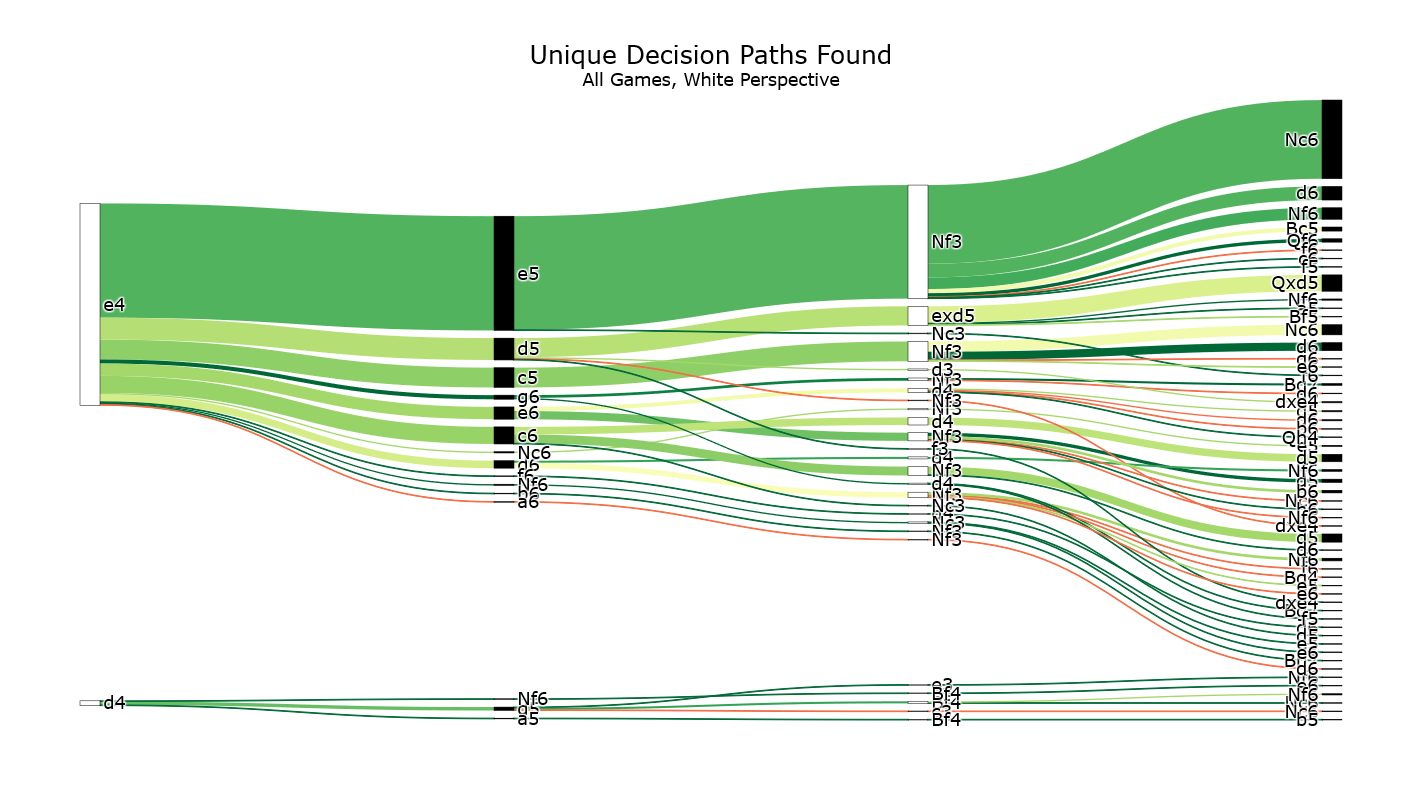

In [26]:
nodes = build_tree(all_games_list, hero_res_list)
data = format_data(nodes)
fig = go.Figure(data=data)

fig.update_layout(title_text=f"Unique Decision Paths Found<br><sup>All Games, {color} Perspective</sup>",
                  title_font_size=25,
                  title_x=0.5,
                  title_y=.92,
                  font=dict(size=18,color="black"),
                  width=800,
                  height=800)
fig

## Build Filtered Decision Tree.

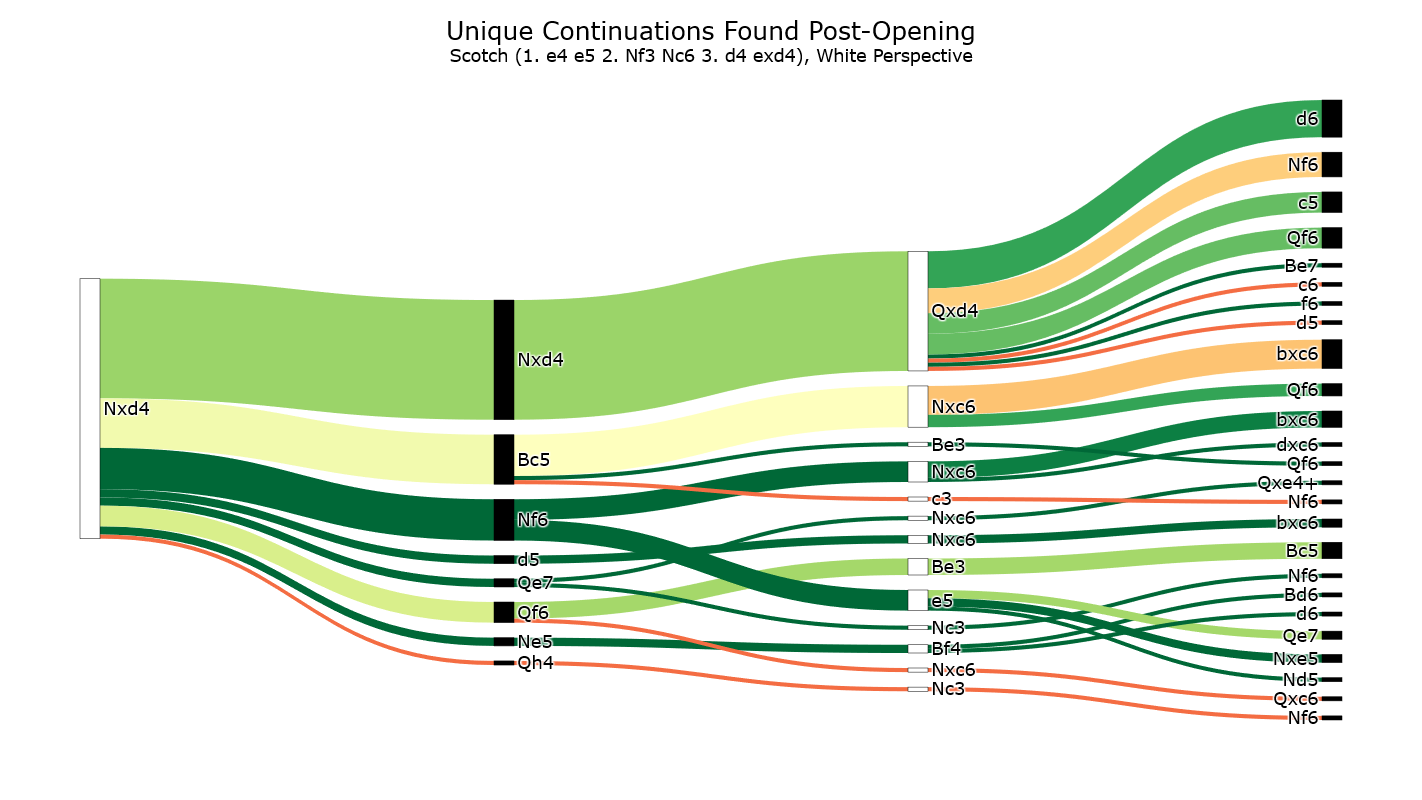

In [27]:
nodes_filtered = build_tree(game_list_filtered, result_list_filtered, max_depth=4)
data_filtered = format_data(nodes_filtered)
fig = go.Figure(data=data_filtered)

fig.update_layout(title_text=f"Unique Continuations Found Post-Opening<br><sup>{opening[1]} ({game_string(opening[0])}), {color} Perspective</sup>",
                  title_font_size=25,
                  title_x=0.5,
                  title_y=.95,
                  font=dict(size=18,color="black"),
                  width=800,
                  height=800)
fig

## Count decision paths.

In [28]:
unique_pos = {}
for node in nodes:
    if node.depth in unique_pos:
        unique_pos[node.depth].append((node.game_string(), node.visits))
    else:
        unique_pos[node.depth] = [(node.game_string(), node.visits)]

In [29]:
depth_x = [0]
paths_y = [1]
for i in unique_pos:
    depth_x.append(i)
    paths_y.append(len(unique_pos[i]))
    print(f"Depth {i}: {len(unique_pos[i])} unique decision paths found.")
print(depth_x)
print(paths_y)

Depth 1: 2 unique decision paths found.
Depth 2: 15 unique decision paths found.
Depth 3: 26 unique decision paths found.
Depth 4: 55 unique decision paths found.
[0, 1, 2, 3, 4]
[1, 2, 15, 26, 55]


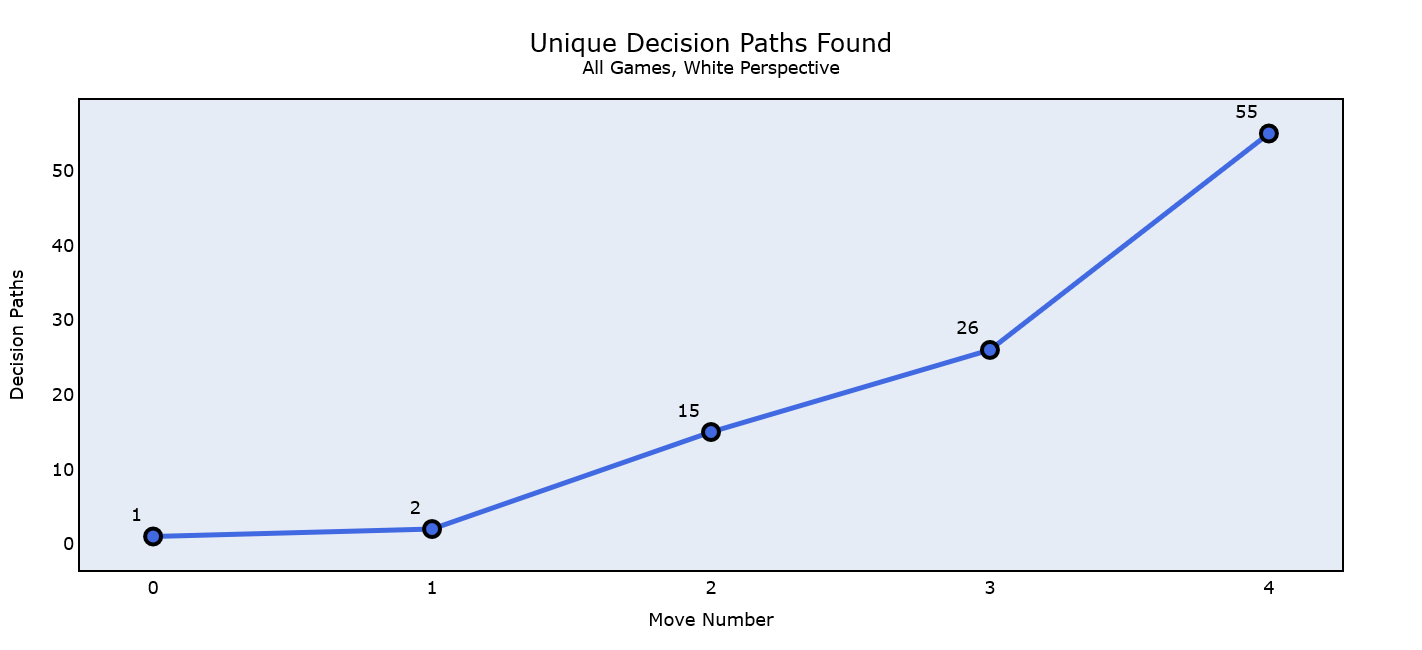

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=depth_x, 
                         y=paths_y,
                         line = dict(color="royalblue", width=5),
                         mode="lines+markers+text",
                         marker = dict(size=16, line=dict(width=4, color="black")),
                         text=paths_y,
                         textposition="top left",
                         textfont=dict(size=18, color="black")
                        )
             )
fig.update_layout(title_text=f"Unique Decision Paths Found<br><sup>All Games, {color} Perspective</sup>",
                  title_font_size=25,
                  title_x=0.5,
                  title_y=.92,
                  xaxis_title="Move Number",
                  yaxis_title="Decision Paths",
                  xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1, showgrid=False, zeroline=False, title_font=dict(size=18)),
                  yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 10, showgrid=False, zeroline=False, title_font=dict(size=18)),
                  font=dict(size=18,color="black"),
                  width=800,
                  height=650)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show()

## Count decision paths for filtered decision tree.

In [31]:
nodes_filtered = build_tree(game_list_filtered, result_list_filtered, max_depth=6)
unique_pos_filtered = {}
for node in nodes_filtered:
    if node.depth in unique_pos_filtered:
        unique_pos_filtered[node.depth].append((node.game_string(), node.visits))
    else:
        unique_pos_filtered[node.depth] = [(node.game_string(), node.visits)]

In [32]:
depth_x_filtered = [0]
paths_y_filtered = [1]
for i in unique_pos_filtered:
    depth_x_filtered.append(i)
    paths_y_filtered.append(len(unique_pos_filtered[i]))
    print(f"Depth {i}: {len(unique_pos_filtered[i])} unique decision paths found.")
print(depth_x_filtered)
print(paths_y_filtered)

Depth 1: 1 unique decision paths found.
Depth 2: 8 unique decision paths found.
Depth 3: 13 unique decision paths found.
Depth 4: 25 unique decision paths found.
Depth 5: 37 unique decision paths found.
Depth 6: 51 unique decision paths found.
[0, 1, 2, 3, 4, 5, 6]
[1, 1, 8, 13, 25, 37, 51]


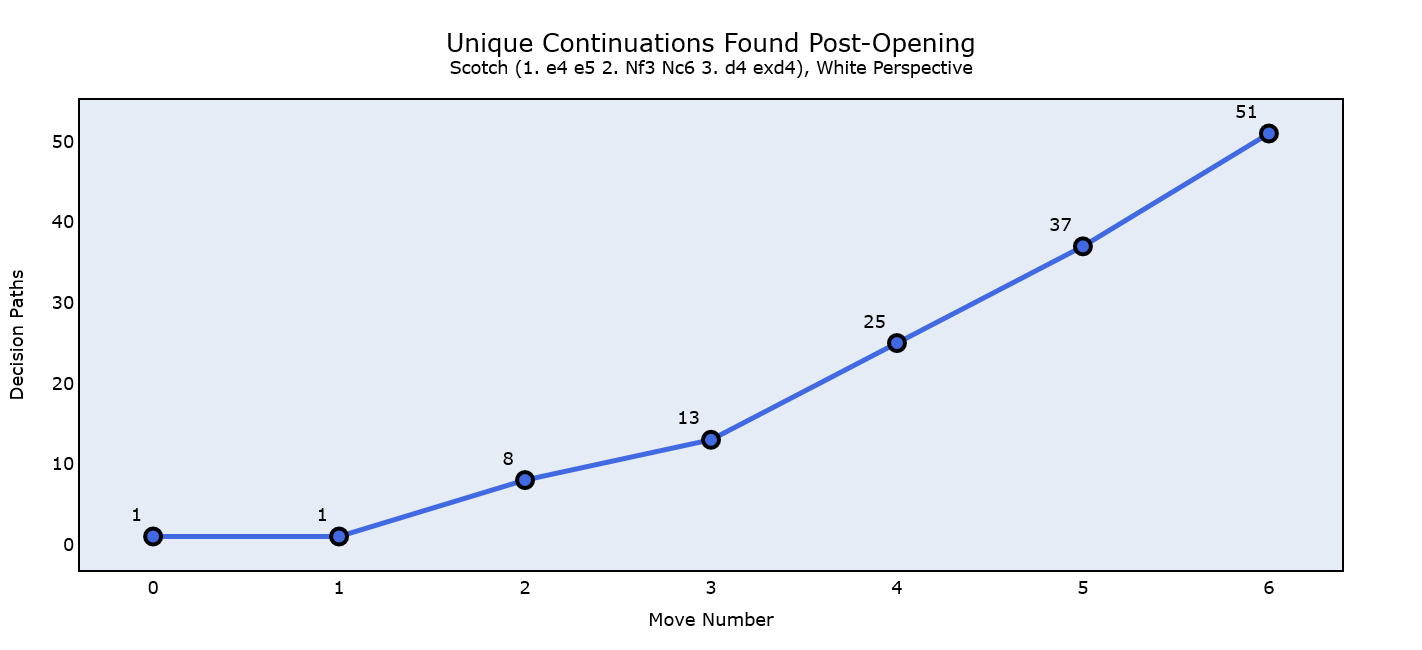

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=depth_x_filtered, 
                         y=paths_y_filtered,
                         line = dict(color="royalblue", width=5),
                         mode="lines+markers+text",
                         marker = dict(size=16, line=dict(width=4, color="black")),
                         text=paths_y_filtered,
                         textposition="top left",
                         textfont=dict(size=18, color="black")
                        )
             )
fig.update_layout(title_text=f"Unique Continuations Found Post-Opening<br><sup>{opening[1]} ({game_string(opening[0])}), {color} Perspective</sup>",
                  title_font_size=25,
                  title_x=0.5,
                  title_y=.92,
                  xaxis_title="Move Number",
                  yaxis_title="Decision Paths",
                  xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1, showgrid=False, zeroline=False, title_font=dict(size=18)),
                  yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 10, showgrid=False, zeroline=False, title_font=dict(size=18)),
                  font=dict(size=18,color="black"),
                  width=800,
                  height=650)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show()

## Create table with opening line/variation percentages.

In [34]:
scotch_main = (["Nxd4"], "Main Line")
scotch_gambit = (["Bc4"], "Scotch Gambit")
scotch_goring_gambit = (["c3"], "Goring Gambit")
scotch_relfsson_gambit = (["Bb5"], "Relfsson Gambit")

scotch_main_classical = (["Nxd4", "Bc5"], "Classical Variation")
scotch_main_schmidt = (["Nxd4", "Nf6"], "Schmidt Variation")
scotch_main_steinitz = (["Nxd4", "Qh4"], "Steinitz Variation")

lines = [scotch_main,
         scotch_gambit,
         scotch_goring_gambit,
         scotch_relfsson_gambit,
         scotch_main_classical,
         scotch_main_schmidt,
         scotch_main_steinitz]

In [35]:
line_records = []
for line in lines:
    line_record = []
    line_record.append(len(line[0]))
    line_record.append(line[1])
    line_record.append(line[0])
    count = 0
    total = 0
    for i in unique_pos_filtered[len(line[0])]:
        if list_from_game_string(i[0]) == line[0]:
            total += i[1]
        count += i[1]
    line_record.append(count)
    line_record.append(total)
    line_record.append(round(total/count,3))
    line_records.append(line_record)
    print(line_record)

[1, 'Main Line', ['Nxd4'], 63, 63, 1.0]
[1, 'Scotch Gambit', ['Bc4'], 63, 0, 0.0]
[1, 'Goring Gambit', ['c3'], 63, 0, 0.0]
[1, 'Relfsson Gambit', ['Bb5'], 63, 0, 0.0]
[2, 'Classical Variation', ['Nxd4', 'Bc5'], 63, 12, 0.19]
[2, 'Schmidt Variation', ['Nxd4', 'Nf6'], 63, 10, 0.159]
[2, 'Steinitz Variation', ['Nxd4', 'Qh4'], 63, 1, 0.016]


## Build table. Add row for other "unnamed" side line variations. Drop lines with 0 occurrences.

In [36]:
df = pd.DataFrame(columns=["depth", "line_name", "move_order", "total_visits", "line_visits", "pct"], data=line_records)
df = df[(df["line_visits"] != 0)]
df.reset_index(drop=True, inplace=True)

In [37]:
for i in list(df.depth.unique()):
    diff = df[(df["depth"] == i)].total_visits.iloc[-1] - df[(df["depth"] == i)].line_visits.sum()
    total_visits = df[(df["depth"] == i)].total_visits.iloc[-1]
    if diff != 0:
        df.loc[len(df.index)] = [i, "Other Line", [], total_visits, diff, round(diff/total_visits, 3)]
df

,depth,line_name,move_order,total_visits,line_visits,pct
0,1,Main Line,[Nxd4],63,63,1.000
1,2,Classical Variation,"[Nxd4, Bc5]",63,12,0.190
2,2,Schmidt Variation,"[Nxd4, Nf6]",63,10,0.159
3,2,Steinitz Variation,"[Nxd4, Qh4]",63,1,0.016
4,2,Other Line,[],63,40,0.635


## Create Pie Chart to show distribution of various lines played.

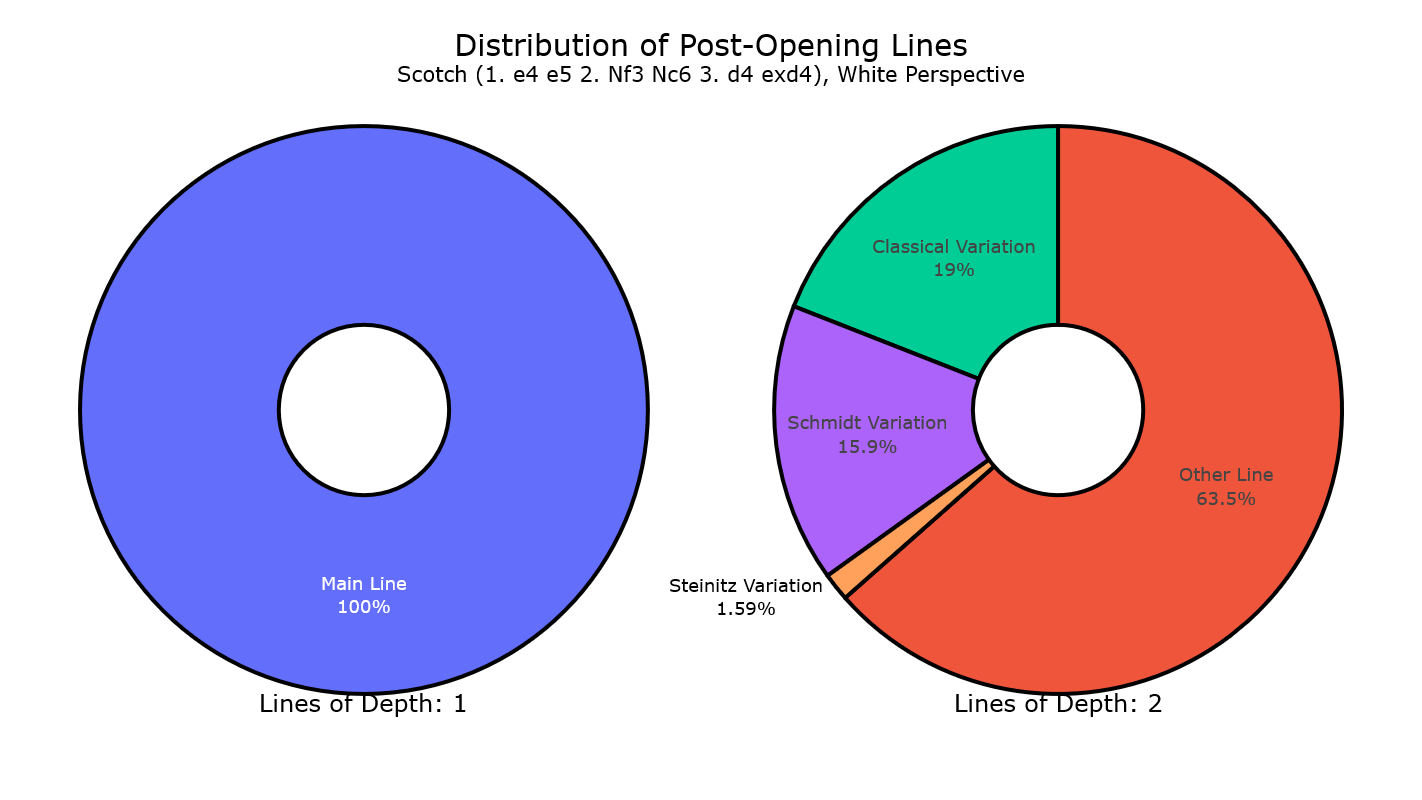

In [44]:
depths = list(df.depth.unique())
specs = [[{'type':'domain'} for i in depths]]
subplot_titles = [f"Lines of Depth: {i}" for i in depths]
              
fig = go.Figure()
fig = make_subplots(rows=1, cols=len(depths), 
                    specs=specs, 
                    subplot_titles=subplot_titles)

for i in depths:
    labels = df[(df["depth"] == i)].line_name.to_list()
    values = df[(df["depth"] == i)].line_visits.to_list()
    fig.add_trace(go.Pie(labels=labels, values=values, hole=0.3), 1, i)

fig.update_traces(textinfo="label+percent", 
                  textfont_size=18,
                  textposition="auto",
                  marker=dict(line=dict(color="black", width=4)),
                  showlegend = False
                 )
fig.update_layout(title_text=f"Distribution of Post-Opening Lines<br><sup>{opening[1]} ({game_string(opening[0])}), {color} Perspective</sup>",
                  title_font_size=30,
                  title_x=0.5,
                  title_y=.93,
                  font=dict(size=18,color="black"),
                  width=1350,
                  height=800)
fig.layout.annotations[0].update(y=0, font=dict(size = 24))
fig.layout.annotations[1].update(y=0, font=dict(size = 24))
fig.show()